![MuJoCo banner](https://raw.githubusercontent.com/google-deepmind/mujoco/main/banner.png)







### Copyright notice

> <p><small><small>Copyright 2025 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Locomotion in The Playground! <a href="https://colab.research.google.com/github/google-deepmind/mujoco_playground/blob/main/learning/notebooks/locomotion.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a>

In this notebook, we'll walk through a few locomotion environments available in MuJoCo Playground.

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".


In [1]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

Thu Jun 26 14:18:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:41:00.0  On |                  Off |
|  0%   44C    P8             21W /  450W |     858MiB /  24564MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# @title Import packages for plotting and creating graphics
import json
import itertools
import time
from typing import Callable, List, NamedTuple, Optional, Union
import numpy as np

# Graphics and plotting.
print("Installing mediapy:")
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [3]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
#@title Import The Playground

from mujoco_playground import wrapper
from mujoco_playground import registry
from mujoco_playground.config import locomotion_params

# Locomotion

MuJoCo Playground contains a host of quadrupedal and bipedal environments (all listed below after running the command).

In [5]:
registry.locomotion.ALL_ENVS

('ApolloJoystickFlatTerrain',
 'BarkourJoystick',
 'BerkeleyHumanoidJoystickFlatTerrain',
 'BerkeleyHumanoidJoystickRoughTerrain',
 'WolfgangJoystickFlatTerrain',
 'WolfgangJoystickRoughTerrain',
 'G1JoystickFlatTerrain',
 'G1JoystickRoughTerrain',
 'Go1JoystickFlatTerrain',
 'Go1JoystickRoughTerrain',
 'Go1Getup',
 'Go1Handstand',
 'Go1Footstand',
 'H1InplaceGaitTracking',
 'H1JoystickGaitTracking',
 'Op3Joystick',
 'SpotFlatTerrainJoystick',
 'SpotGetup',
 'SpotJoystickGaitTracking',
 'T1JoystickFlatTerrain',
 'T1JoystickRoughTerrain')

# Bipedal

MuJoCo Playground also comes with a host of bipedal environments, such as the Berkely Humanoid and the Unitree G1/H1. Let's demonstrate a joystick policy on the Berkeley Humanoid. The initial policy takes 17 minutes to train on an RTX 4090.

In [6]:
env_name = 'WolfgangJoystickFlatTerrain'
env = registry.load(env_name)
env_cfg = registry.get_default_config(env_name)
ppo_params = locomotion_params.brax_ppo_config(env_name)

In [7]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  clear_output(wait=True)

  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics["eval/episode_reward"])
  y_dataerr.append(metrics["eval/episode_reward_std"])

  plt.xlim([0, ppo_params["num_timesteps"] * 1.25])
  plt.xlabel("# environment steps")
  plt.ylabel("reward per episode")
  plt.title(f"y={y_data[-1]:.3f}")
  plt.errorbar(x_data, y_data, yerr=y_dataerr, color="blue")

  display(plt.gcf())

randomizer = registry.get_domain_randomizer(env_name)
ppo_training_params = dict(ppo_params)
network_factory = ppo_networks.make_ppo_networks
if "network_factory" in ppo_params:
  del ppo_training_params["network_factory"]
  network_factory = functools.partial(
      ppo_networks.make_ppo_networks,
      **ppo_params.network_factory
  )

train_fn = functools.partial(
    ppo.train, **dict(ppo_training_params),
    network_factory=network_factory,
    randomization_fn=randomizer,
    progress_fn=progress
)

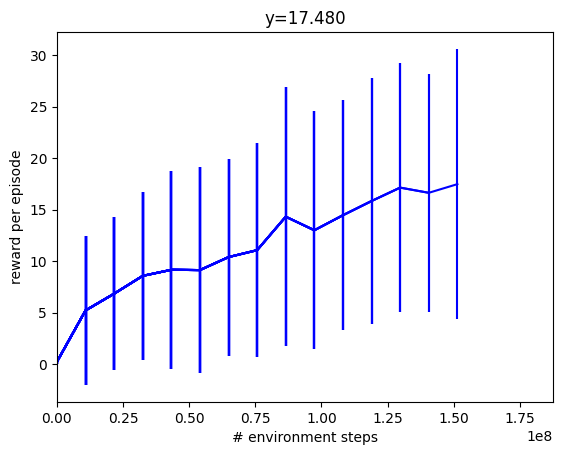

time to jit: 0:03:59.900401
time to train: 0:21:46.480534


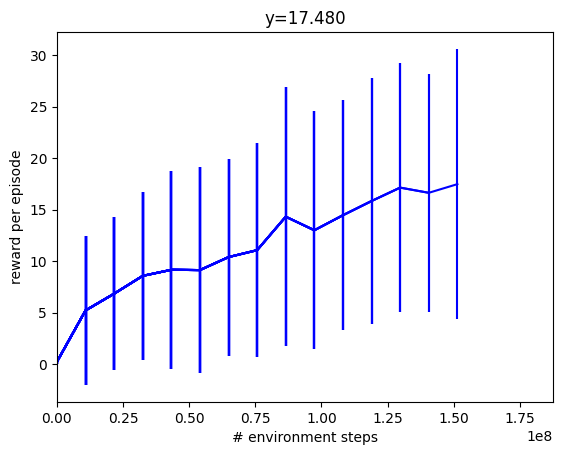

In [8]:
make_inference_fn, params, metrics = train_fn(
    environment=env,
    eval_env=registry.load(env_name, config=env_cfg),
    wrap_env_fn=wrapper.wrap_for_brax_training,
)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [9]:
#@title Rollout and Render
from mujoco_playground._src.gait import draw_joystick_command

env = registry.load(env_name)
eval_env = registry.load(env_name)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(make_inference_fn(params, deterministic=True))

rng = jax.random.PRNGKey(1)

rollout = []
modify_scene_fns = []

x_vel = 0.5  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
yaw_vel = 0.4  #@param {type: "number"}
command = jp.array([x_vel, y_vel, yaw_vel])

phase_dt = 2 * jp.pi * eval_env.dt * 1.5
phase = jp.array([0, jp.pi])

for j in range(4):
  print(f"episode {j}")
  state = jit_reset(rng)
  state.info["phase_dt"] = phase_dt
  state.info["phase"] = phase
  for i in range(env_cfg.episode_length):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    if state.done:
      break
    state.info["command"] = command
    rollout.append(state)

    xyz = np.array(state.data.xpos[eval_env.mj_model.body("torso").id])
    xyz += np.array([0, 0.0, 0])
    x_axis = state.data.xmat[eval_env._torso_body_id, 0]
    yaw = -np.arctan2(x_axis[1], x_axis[0])
    modify_scene_fns.append(
        functools.partial(
            draw_joystick_command,
            cmd=state.info["command"],
            xyz=xyz,
            theta=yaw,
            scl=np.linalg.norm(state.info["command"]),
        )
    )

render_every = 1
fps = 1.0 / eval_env.dt / render_every
print(f"fps: {fps}")
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640*2,
    height=480,
    modify_scene_fns=mod_fns,
)
media.show_video(frames, fps=fps, loop=False)

episode 0


2025-06-26 14:45:19.647904: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


episode 1
episode 2
episode 3
fps: 50.0


100%|██████████| 1751/1751 [00:10<00:00, 170.97it/s]


🙌 Hasta la vista!